# GeoJSON Towns Data Reduction with K-Means

## Import Libraries

In [1]:
import numpy as np
import scipy as sp
import sklearn.cluster as clt
import matplotlib.pyplot as plt

## Problem Understanding & Intuitive Idea

#### At CLUES_NoteBook file we wanted to plot a geographical map with the federal boundaries of México but it delays 10 seconds to show the original information. Therefore, we must reduce our data to speed up our DashBoard while keeping chiefly morphological information. To conceive a better understanding about our problem let's set up an example.

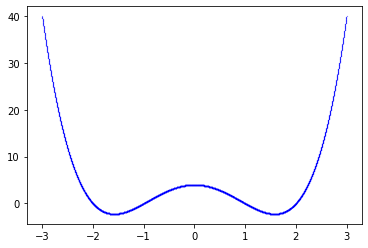

In [2]:
x = np.linspace(-3,3,10000);
y = x**4 - 5*x**2 + 4;

plt.plot(x,y, "bo", markersize=0.1)

#### We want to reduce the necessary quantity of points to draw the function "y" (10,000 points) without losing essential morphological information. Let's suppose we'll reduce this data to 1% of its total

In [3]:
clusters = int(x.size * 0.01)

print(x.size)
print(clusters)

10000
100


In [4]:
data = np.array([x,y]).T
data

array([[-3.        , 40.        ],
       [-2.99939994, 39.95321296],
       [-2.99879988, 39.90646119],
       ...,
       [ 2.99879988, 39.90646119],
       [ 2.99939994, 39.95321296],
       [ 3.        , 40.        ]])

#### We proceed to generate the K-means algorithm. We set the number of clusters, a select initial centroids at random from data, a maximum number of iterations and number of times the algorithm will choose different initial centroids. 

In [5]:
kmCirculo = clt.KMeans(n_clusters=clusters, init="random", 
                       n_init=10, max_iter=300).fit(data)

#### As it can be seen in the following section, the reduced data could keep morphological information from the original dataset with few points (100 out of 10,000)

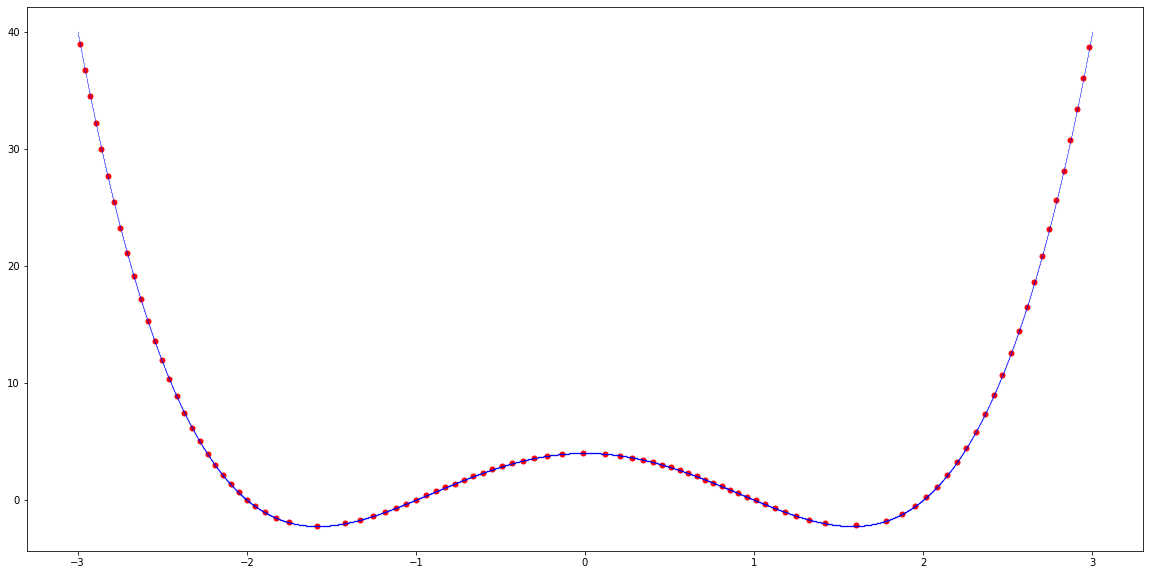

In [8]:
data2 = kmCirculo.cluster_centers_
plt.figure(figsize=(20,10))
plt.plot(data2.T[0], data2.T[1], "ro", markersize=5)
plt.plot(x,y, "bo", markersize=0.1)

#### **If you want to know the full process to achive data reduction, I encourage you to look at KM_GeoJSON_Ent Jupyter Notebook**

## GeoJSON Data

In [8]:
import json as js
import urllib.request

EstadosLink = "https://www.gits.igg.unam.mx/repositoriodecapas/geojson/u_territorial_municipios_mgn_inegi_2013.json"

with urllib.request.urlopen(EstadosLink) as url:
    jsMun = js.loads(url.read().decode())
    
with urllib.request.urlopen(EstadosLink) as url:
    jsMun2 = js.loads(url.read().decode())


## Define Functions

In [15]:
def selectDivision(divisiones):
    if len(divisiones) > 1:
        
        puntos = 0
        posicion = 0
        
        for j in range(len(divisiones)):
            cantidadP = len(divisiones[j][0])
            
            if cantidadP > puntos:
                puntos = len(divisiones[j][0])
                posicion = j
    else:
        posicion = 0
        puntos = len(divisiones[0][0])
        
    return posicion, puntos

In [16]:
def SelectGreater(divisiones, cantidad=3):
    
    length = len(divisiones)
    
    List = np.zeros(shape=(length,2), dtype=int)
    
    if length > 1:
                
        for j in range(length):
            
            List[j,0] = int(j)
            List[j,1] = len(divisiones[j][0])
    else:
        List[0,0] = int(0)
        List[0,1] = len(divisiones[0][0])
    
    return List[np.argsort(List[:,1])][-cantidad:]

In [17]:
def PMF_puntos(array):
    Anterior = np.insert(array.T, 0, array.T[-1], axis=0)
    Anterior = np.delete(Anterior, len(Anterior)-1, axis = 0)
    
    Posterior = np.insert(array.T, -1, array.T[0], axis=0)
    Posterior = np.delete(Posterior, 0, axis = 0)
    
    B1 = (Anterior - array.T)
    B2 = (Posterior - array.T)
    
    total = (abs(B1 + B2)/2) #abs

    Dens = total.T[0] * total.T[1]

    Dens = Dens / sum(Dens)
    
    return Dens

In [18]:
def PMF_puntos2(array):
    Anterior = np.insert(array.T, 0, array.T[-1], axis=0)
    Anterior = np.delete(Anterior, len(Anterior)-1, axis = 0)
    
    Posterior = np.insert(array.T, len(array.T), array.T[0], axis=0)
    Posterior = np.delete(Posterior, 0, axis = 0)
    
    Va = (array.T - Anterior)
    Vp = (array.T - Posterior)
    
    Ca = np.sqrt((Va[:,0])**2 + (Va[:,1])**2)
    Cp = np.sqrt((Vp[:,0])**2 + (Vp[:,1])**2)
    
    Dens = Ca*Cp
    
    Dens /= np.sum(Dens)
    #Dens = np.around(Dens, decimals=10)
    
    return Dens

In [19]:
def promPMF(array, clusters, iterations, PMF):
    iterations = iterations          ######################
    index = np.zeros(shape = (clusters))

    #dataEstado = np.zeros(shape = (clusters,2))
    
    for i in range(iterations):
        index += np.sort(np.random.choice(array.shape[1], clusters, replace=False, p=PMF))   #############
        
    index = np.around(index / iterations).astype("int32")
    
    return index

In [20]:
def Cost_Func(observed, expected):
    dif_Ob = observed - observed.min()
    dif_Exp = expected - expected.min()
    
    dataEstadoNorm = (dif_Ob) / (dif_Ob).max()
    EstadoNorm = (dif_Exp) / (dif_Exp).max()
    
    dataEstadoNorm *= 100
    EstadoNorm *= 100
    
    Cost = ((EstadoNorm - dataEstadoNorm) ** 2).sum()
    
    return Cost

## Algorithm for Data Reduction

In [21]:
import numpy as np
import sklearn.cluster as clt
import matplotlib.pyplot as plt

municipios = len(jsMun["features"])
#divisiones = np.zeros(shape = (entidades))

Estados = np.zeros(shape=(32), dtype=int)
MunEstados = np.zeros(shape=(32), dtype=int)

for Municipio in range(municipios):
    #divisiones = jsMun["features"][i]["geometry"]["coordinates"]
    #posDiv, cantPunt = selectDivision(divisiones)
    
    totalMunicipio = 0
    
    for Division in range(len(jsMun["features"][Municipio]["geometry"]["coordinates"])):
        totalMunicipio += len(jsMun["features"][Municipio]["geometry"]["coordinates"][Division][0])
    
    CodEst = int(jsMun["features"][Municipio]["properties"]["cvegeoedo"]) - 1
    Estados[CodEst] += totalMunicipio
    MunEstados[CodEst] += 1
    

#[["Estado: {} | {} | {}% ".format(i+1, Estados[i], round(Estados[i]*100/np.sum(Estados),2))] for i in range(32)]

Ponderacion = 1 - np.around(Estados/np.sum(Estados), 4)
print(Ponderacion)
print(Estados)

[0.997  0.9865 0.9833 0.9925 0.9902 0.995  0.9572 0.9513 0.9955 0.9755
 0.9738 0.9566 0.955  0.9065 0.9537 0.9398 0.9898 0.9867 0.9765 0.9226
 0.8956 0.9925 0.9899 0.9843 0.9872 0.9825 0.9828 0.9813 0.9813 0.8895
 0.981  0.9669]
[  9860  44458  54837  24840  32160  16422 140752 160369  14686  80730
  86185 142694 148159 307548 152266 197996  33571  43678  77177 254507
 343431  24534  33133  51757  42227  57437  56628  61472  61663 363643
  62637 108793]


In [56]:
import numpy as np
import sklearn.cluster as clt
import matplotlib.pyplot as plt

entidades = len(jsMun["features"])
divisiones = np.zeros(shape = (entidades))

for i in range(entidades):
    
    #CodEst = int(jsMun["features"][i]["properties"]["cvegeoedo"]) - 1
    
    divisiones = jsMun["features"][i]["geometry"]["coordinates"]
    #posDiv, cantPunt = selectDivision(divisiones)
    
    CodEst = int(jsMun["features"][i]["properties"]["cvegeoedo"]) - 1
    
    ### Calcular Porentaje de Estado
    PorcEstado = Ponderacion[CodEst]
    
    ### Calcular Porcentaje de Municipio
    totLoc = 0
    for localidad in range(len(jsMun["features"][i]["geometry"]["coordinates"])): 
        totLoc += len(jsMun["features"][i]["geometry"]["coordinates"][localidad][0])
        
    PorcMun = 1 - round((totLoc/Estados[CodEst]), 4)
    
    CountJsMun2 = 0
    
    GreaterNumber = SelectGreater(jsMun["features"][i]["geometry"]["coordinates"])
    jsMun2["features"][i]["geometry"]["coordinates"] = [0,] * len(GreaterNumber)
    
    for Division in GreaterNumber:
        
        ### Calcular Porcentaje de Localidad
        PorcLoc = 1 - round(len(jsMun["features"][i]["geometry"]["coordinates"][Division[0]][0])/totLoc, 4)
        
        ### Calcular Porcentaje total
        
        if PorcLoc == 0:
            PorcTotal = PorcEstado * PorcMun
        else:
            PorcTotal = PorcEstado * PorcMun * PorcLoc
            
        PorcTotal = 0.5 if PorcTotal>0.5 else PorcTotal
        
        print("{} | {} | {}".format(CodEst,i,Division[0]))
        print("Est:{} | Mun:{} | Loc:{} => {}".format(PorcEstado,PorcMun,PorcLoc,PorcTotal))
        
        Municipio = np.array(divisiones[Division[0]][0]).T
        
        _, idx = np.unique(Municipio.T, axis=0, return_index=True)
        Municipio = Municipio.T[np.sort(idx)].T
        
        
        PMF = PMF_puntos2(Municipio)
        clusters = int(Municipio.shape[1] * PorcTotal)#int(Municipio.shape[1] * (round(np.exp((-1) * Ponderacion[CodEst] / 20),2) / 2))     #int(Municipio.shape[1] * 0.50)
        
        cost = 100
        limite = 0

        count = 0
        maxIter = 30

        memCost = np.zeros(shape=(maxIter), dtype=float)
        memData = [0,] * maxIter

        while (cost > limite) and (count < maxIter):

            index = promPMF(Municipio, clusters, np.ceil(Municipio[1].size * 0.1).astype(int), PMF)    #round(Municipio[1].size * 0.1)
            
            #print("Clust: {} | ".format(clusters,Estado.T[index].shape))
            
            
            kmMun = clt.KMeans(n_clusters=clusters, init=Municipio.T[index],
                                  n_init=1, max_iter=50).fit(Municipio.T)

            dataMun = kmMun.cluster_centers_ 

            dataMun[-1] = dataMun[0]

            #dataEstado[0] = Estado.T[0]
            #dataEstado[-1] = Estado.T[-1]

            cost = Cost_Func(dataMun.T[1], Municipio.T[index].T[1])

            memCost[count] = cost
            memData[count] = dataMun
            
            limite = np.around(3.3 ** np.log10(Municipio[0].size)) #/ 2

            count += 1

            #print(i, ": ", cost, " | ", limite)

        #dataEstado = np.vstack((dataEstado,dataEstado[0]))
        #dataEstado[-1] = dataEstado[0]

        if count >= maxIter:
            inx = np.where(memCost == memCost.min())[0][0]
            
            jsMun2["features"][i]["geometry"]["coordinates"][CountJsMun2] = [memData[inx].tolist()]
            print(memCost.min())
            print("Pasé por el memCost")

        else:
            jsMun2["features"][i]["geometry"]["coordinates"][CountJsMun2] = [dataMun.tolist()]
            print(cost)
            print("No pasé por memCost")
        
        CountJsMun2 += 1
        
        print("\n")


0 | 0 | 0
Est:0.997 | Mun:0.8768 | Loc:0.0 => 0.5
10.486049970283783
No pasé por memCost


0 | 1 | 0
Est:0.997 | Mun:0.8688 | Loc:0.0 => 0.5
18.0372387059097
No pasé por memCost


0 | 2 | 0
Est:0.997 | Mun:0.8739 | Loc:0.0 => 0.5
18.324094192186855
No pasé por memCost


0 | 3 | 0
Est:0.997 | Mun:0.9519 | Loc:0.0 => 0.5
8.83127308229244
No pasé por memCost


0 | 4 | 0
Est:0.997 | Mun:0.8889 | Loc:0.0 => 0.5
13.95399640219392
No pasé por memCost


0 | 5 | 0
Est:0.997 | Mun:0.9231 | Loc:0.0 => 0.5
29.339089764466763
No pasé por memCost


0 | 6 | 0
Est:0.997 | Mun:0.9029 | Loc:0.0 => 0.5
27.31129578926394
No pasé por memCost


0 | 7 | 0
Est:0.997 | Mun:0.9202 | Loc:0.0 => 0.5
6.364371809319308
No pasé por memCost


0 | 8 | 0
Est:0.997 | Mun:0.9289000000000001 | Loc:0.0 => 0.5
1.076330488041299
No pasé por memCost


0 | 9 | 0
Est:0.997 | Mun:0.9355 | Loc:0.0 => 0.5
6.173417290355371
No pasé por memCost


0 | 10 | 0
Est:0.997 | Mun:0.929 | Loc:0.0 => 0.5
13.550807853830335
No pasé por memCos

## Save GeoJSON reduced data

In [ ]:
import copy

jsMun2Copy = copy.deepcopy(jsMun2)

jsMun2Copy["features"] = []
munGeneral = []

for Est in range(32):
    munNuevo = []
    
    for Mun in range(len(jsMun2["features"])):
        
        if int(jsMun2["features"][Mun]["properties"]["cvegeoedo"]) == (Est+1):
            jsMun2["features"][Mun]["id"] = int(jsMun2["features"][Mun]["properties"]["cve_mun"])
            munNuevo += [copy.deepcopy(jsMun2["features"][Mun])]
    
    jsMun2Copy["features"] = munNuevo
    munGeneral += [copy.deepcopy(jsMun2Copy)]

In [ ]:
import json as js
import os

MunLink ='CleanData'

os.makedirs(MunLink, exist_ok=True) 

with open(MunLink + "/MunGeo.json", 'w') as json_file:
  js.dump(munGeneral, json_file)